Diego Armando Mijares Ledezma - A01722421 

Pedro Soto Juárez - A00837560

Alexei Carrillo Acosta - A01285424 

Marcos Renato Aquino Garcia - A00835576 

Mauricio Octavio Valencia Gonzalez - A01234397

# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController
import itertools
from collections import defaultdict



Just run the next cell to load the data.

In [2]:
diabetes = pd.read_csv('diabetes-dataset-mod2.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Create a new column called `Overweight` in which a person whose `BMI` is above 25 will be tagged as a one, and zero otherwise.

In [3]:
diabetes['Overweight'] = (diabetes['BMI'] > 25).astype(int)

You are to code the next function, which discretize all the variables of the dataset, except `Outcome` and `Overweight`. Remember that you will discretize with respect to the quantiles of each variables: if a variable value is less than Q1, then said value is replaced by a **zero**; if the given value is greater or equal than Q1 but less than Q2, then the value should be replaced by a **one**; if the variable value is greater or equal than Q2 but less than Q3, then the value should be replaced by a **two**; finally, if a variable value is greater than Q3, it should be assigned the value **three**. 

In [4]:
def discretize(df):
    """
    This function receives a dataframe as input and returns a dataframe in which each variable has been 
    discretized. 
    """
    discretized_df = df.copy()
    
    for column in df.columns:
        if column not in ['Outcome', 'Overweight']:
            q1, q2, q3 = df[column].quantile([0.25, 0.5, 0.75])
            discretized_df[column] = pd.cut(df[column], 
                                            bins=[-float('inf'), q1, q2, q3, float('inf')], 
                                            labels=[0, 1, 2, 3])
    
    return discretized_df

In [5]:
discrete_df = discretize(diabetes)
discrete_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,3,0,2,0,3,1,1
1,0,0,3,2,2,3,0,0,0,1
2,0,3,0,0,0,3,3,2,1,1
3,0,2,1,3,3,3,1,0,1,1
4,0,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,1,2,2,1,1,2,0,1
1996,3,3,1,3,2,2,3,2,1,1
1997,2,0,2,0,0,1,2,3,0,1
1998,0,2,3,3,2,3,1,1,1,1


In the following cel you are to create two dictionaries: `graph` will store the topology of the Bayesian network, so each element is associated to a list that contains the names of the parents of said element; `values` stores the values that each variable of the network takes, which are the discrete values that were computed above.

In [7]:
graph = {'Overweight': [], 
         'DiabetesPedigreeFunction': [], 
         'Age': [], 
         'Pregnancies': [],
         'SkinThickness' : ['Overweight'], 
         'BMI': ['Overweight'],
         'Outcome': ['Age', 'DiabetesPedigreeFunction', 'Pregnancies', 'Overweight'],
         'BloodPressure': ['Outcome', 'Overweight'],
         'Insulin': ['Outcome'],
         'Glucose': ['Outcome']}

values = {
    'Overweight': [0, 1],
    'DiabetesPedigreeFunction': [0, 1, 2, 3],
    'Age': [0, 1, 2, 3],
    'Pregnancies': [0, 1, 2, 3],
    'SkinThickness': [0, 1, 2, 3],
    'BMI': [0, 1, 2, 3],
    'Outcome': [0, 1],
    'BloodPressure': [0, 1, 2, 3],
    'Insulin': [0, 1, 2, 3],
    'Glucose': [0, 1, 2, 3]
}

The next function obtains the probabilities of a given node. This function will be used later to create a dictionary in which each element contains a node and its list of probabilities.

In [11]:
def probabilities(df, node):
    """
    This function computes the probabilities of a given node.
    """
    probabilities_list = []
    parents = graph[node]
    node_values = [str(v) for v in values[node]]
    
    if not parents:
        counts = df[node].astype(str).value_counts().sort_index()
        total = counts.sum()
        probabilities_list = [(count / total) for count in counts]
        # Ensure we have a probability for each possible value
        probabilities_list += [0] * (len(node_values) - len(probabilities_list))
    else:
        parent_combinations = list(itertools.product(*[map(str, values[parent]) for parent in parents]))
        counts = defaultdict(lambda: defaultdict(int))
        
        for _, row in df.iterrows():
            parent_values = tuple(str(row[parent]) for parent in parents)
            counts[parent_values][str(row[node])] += 1
        
        for combination in parent_combinations:
            total = sum(counts[combination].values())
            if total == 0:
                probabilities_list.extend([1/len(node_values)] * len(node_values))
            else:
                for value in node_values:
                    prob = counts[combination][value] / total
                    probabilities_list.append(prob)
    
    return probabilities_list


The following function must create a dictionary in which item is a node and its corresponding list of probabilities

In [12]:
def tables(df):
    """
    This function returns a dictionary in which each element is a node and its list of probabilities.
    """
    probabilities_tables = {}
    
    for node in graph.keys():
        probabilities_tables[node] = probabilities(df, node)
    
    return probabilities_tables

Create the nodes of the network in this cell. For each line, replace `"node index"` and the empty list by the proper variable name and variable values, respectively.

In [13]:
# Calculate the probability tables
probability_tables = tables(discrete_df)

# Create the nodes
overweight = BbnNode(Variable(0, 'Overweight', [str(v) for v in values['Overweight']]), probability_tables['Overweight'])
diabetes_pedigree_function = BbnNode(Variable(1, 'DiabetesPedigreeFunction', [str(v) for v in values['DiabetesPedigreeFunction']]), probability_tables['DiabetesPedigreeFunction'])
age = BbnNode(Variable(2, 'Age', [str(v) for v in values['Age']]), probability_tables['Age'])
pregnancies = BbnNode(Variable(3, 'Pregnancies', [str(v) for v in values['Pregnancies']]), probability_tables['Pregnancies'])
skin_thickness = BbnNode(Variable(4, 'SkinThickness', [str(v) for v in values['SkinThickness']]), probability_tables['SkinThickness'])
bmi = BbnNode(Variable(5, 'BMI', [str(v) for v in values['BMI']]), probability_tables['BMI'])
outcome = BbnNode(Variable(6, 'Outcome', [str(v) for v in values['Outcome']]), probability_tables['Outcome'])
blood_pressure = BbnNode(Variable(7, 'BloodPressure', [str(v) for v in values['BloodPressure']]), probability_tables['BloodPressure'])
insulin = BbnNode(Variable(8, 'Insulin', [str(v) for v in values['Insulin']]), probability_tables['Insulin'])
glucose = BbnNode(Variable(9, 'Glucose', [str(v) for v in values['Glucose']]), probability_tables['Glucose'])

Implement your graph in the following cell. Add as many nodes and edges as necessary. Replace the strings by the proper variables.

In [14]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(diabetes_pedigree_function) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin_thickness) \
    .add_node(bmi) \
    .add_node(outcome) \
    .add_node(blood_pressure) \
    .add_node(insulin) \
    .add_node(glucose) \
    .add_edge(Edge(overweight, skin_thickness, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(age, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes_pedigree_function, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(pregnancies, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, insulin, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, glucose, EdgeType.DIRECTED))

Do not forget to run this cell and do not modify it, inferences depend on it.

In [15]:
# Convert the BBN to a join tree. Do not modify this cell.

join_tree = InferenceController.apply(bbn)

The following cell is very useful for visualizing your Bayesian network. It is very recommended that you make the necessary changes and run it to verify that your network was implementented correctly.

/var/folders/cc/4n08z0bx25j1czv79jvmgydc0000gn/T/ipykernel_20584/369351684.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


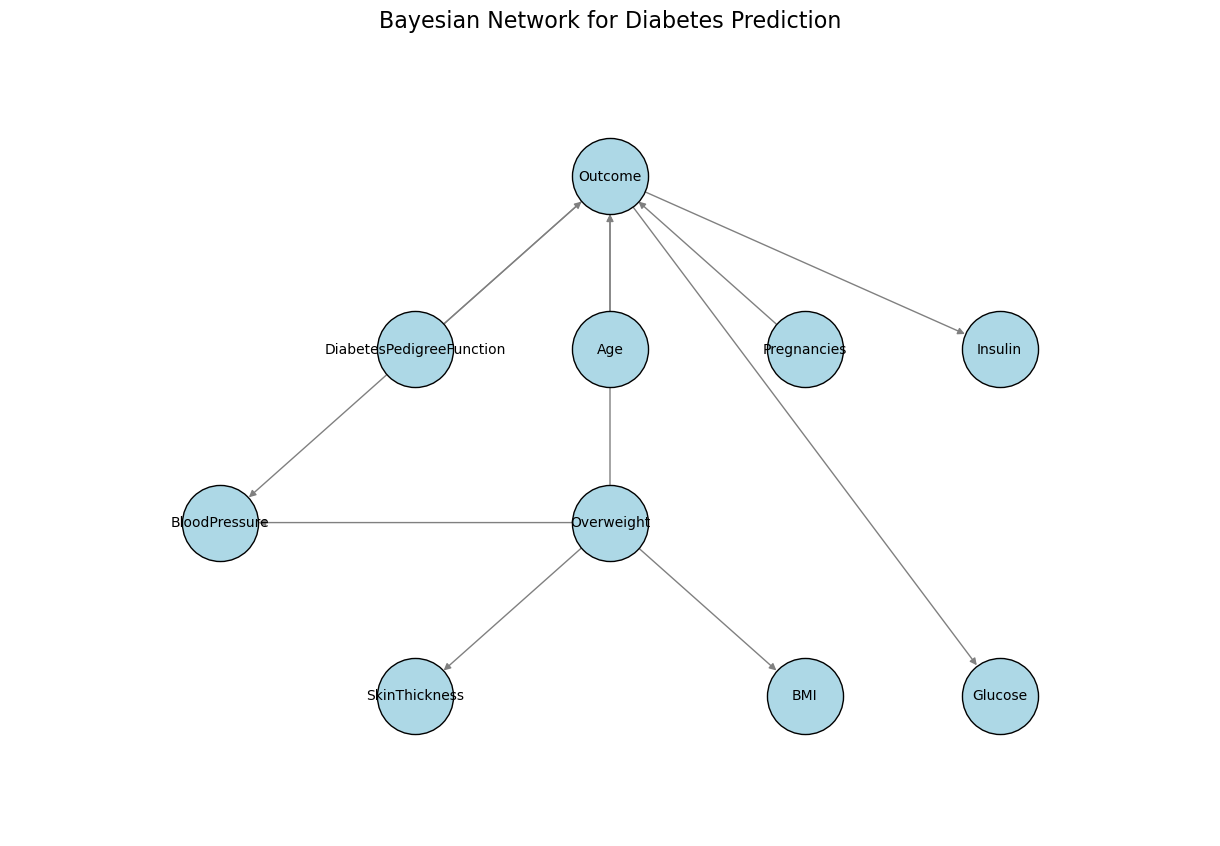

In [16]:
# Set node positions
pos = {
    0: (0, 0),    # Overweight
    1: (-1, 1),   # DiabetesPedigreeFunction
    2: (0, 1),    # Age
    3: (1, 1),    # Pregnancies
    4: (-1, -1),  # SkinThickness
    5: (1, -1),   # BMI
    6: (0, 2),    # Outcome
    7: (-2, 0),   # BloodPressure
    8: (2, 1),    # Insulin
    9: (2, -1)    # Glucose
}

# Set options for graph looks
options = {
    "font_size": 10,
    "node_size": 3000,
    "node_color": "lightblue",
    "edgecolors": "black",
    "edge_color": "gray",
    "linewidths": 1,
    "width": 1,
}

# Generate graph
n, d = bbn.to_nx_graph()

# Create a new figure with a larger size
plt.figure(figsize=(12, 8))

# Draw the graph
nx.draw(n, pos, with_labels=True, labels=d, **options)

# Add a title
plt.title("Bayesian Network for Diabetes Prediction", fontsize=16)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.tight_layout()
plt.show()

The goal of `print_probs` is to print out the probability distributions of all the nodes of the network. You can modify this code to print only the distributions of certain nodes if you find that helpful.

In [17]:
# Define a function for printing marginal probabilities.

def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
    
# Use the above function to print marginal probabilities.

print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.15300
0=1|0.84700
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.28650
4=1|0.22450
4=2|0.24050
4=3|0.24850
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.25000
5=1|0.25350
5=2|0.25550
5=3|0.24100
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.60497
6=1|0.39503
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.48036
8=1|0.02313
8=2|0.24496
8=3|0.25155
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.24411
9=1|0.23812
9=2|0.25016
9=3|0.26760
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.24612
7=1|0.29071
7=2|0.24617
7=3|0.21700
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.25100
1=1|0.25050
1=2|0.24950
1=3|0.24900
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.29150
2=1|0.23350
2=2|0.22950
2=3|0.24550
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.32850
3=1|0.23950
3=2|0.23150
3=3|0.20050
----------------


The function `evidence` helps tyou to create evidence that will be used for making inferences. Do not modify this cell, please.

In [18]:
# To add evidence of events that happened so probability distribution can be recalculated.

def evidence(ev, node_id, val, like):
    node = join_tree.get_bbn_node(node_id)
    if node is None:
        raise ValueError(f"No node found with ID {node_id}")
    
    ev = EvidenceBuilder() \
        .with_node(node) \
        .with_evidence(str(val), like) \
        .build()
    join_tree.set_observation(ev)

Now you are ready to add evidence and print out the new distributions of your network. 

In [19]:
# Use above function to add evidence
# In the code, we add various evidences to the network to see how the marginal probabilities change.

# This is just the first one, we add more after the results.

# Overweight person example - all other categories ignored, all we know is this person is categorized as overweight
evidence('ev1', 0, '1', 1)  # Sets evidence for the Overweight node (ID 0) to value '1'

# Print marginal probabilities
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.25266
4=1|0.18713
4=2|0.27273
4=3|0.28749
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.11452
5=1|0.29929
5=2|0.30165
5=3|0.28453
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.57119
6=1|0.42881
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.48187
8=1|0.02257
8=2|0.23920
8=3|0.25636
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.23399
9=1|0.23438
9=2|0.25154
9=3|0.28009
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.21251
7=1|0.29648
7=2|0.25122
7=3|0.23979
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.25100
1=1|0.25050
1=2|0.24950
1=3|0.24900
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.29150
2=1|0.23350
2=2|0.22950
2=3|0.24550
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.32850
3=1|0.23950
3=2|0.23150
3=3|0.20050
----------------


In [20]:
join_tree = InferenceController.apply(bbn)

In [21]:
# Young athlete (low BMI, low Blood Pressure, low Insulin, high Skin Thickness)
evidence('ev1', 0, '0', 1)  # Not overweight
evidence('ev2', 2, '1', 1)  # Young (20-40 quartile)
evidence('ev3', 5, '0', 1)  # Very low BMI (first quartile)
evidence('ev4', 7, '0', 1)  # Low Blood Pressure (first quartile)
evidence('ev5', 8, '0', 1)  # Low Insulin (first quartile)
evidence('ev6', 4, '3', 1)  # High Skin Thickness (fourth quartile, common in athletes)
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|1.00000
0=1|0.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.00000
4=1|0.00000
4=2|0.00000
4=3|1.00000
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|1.00000
5=1|0.00000
5=2|0.00000
5=3|0.00000
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.87805
6=1|0.12195
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|1.00000
8=1|0.00000
8=2|0.00000
8=3|0.00000
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.32593
9=1|0.26839
9=2|0.23902
9=3|0.16666
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|1.00000
7=1|0.00000
7=2|0.00000
7=3|0.00000
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.25146
1=1|0.25096
1=2|0.24996
1=3|0.24763
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.00000
2=1|1.00000
2=2|0.00000
2=3|0.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.33119
3=1|0.24146
3=2|0.23157
3=3|0.19579
----------------


In [22]:
join_tree = InferenceController.apply(bbn)

In [23]:
# Middle-aged person with pre-diabetes (high Glucose, medium BMI, and slightly high Blood Pressure)
evidence('ev1', 0, '1', 1)  # Overweight
evidence('ev2', 2, '2', 1)  # Middle-aged (40-60 quartile)
evidence('ev3', 5, '2', 1)  # Medium-high BMI (third quartile)
evidence('ev4', 7, '2', 1)  # Slightly high Blood Pressure (third quartile)
evidence('ev5', 8, '1', 1)  # Moderate Insulin (second quartile)
evidence('ev6', 9, '2', 1)  # High Glucose (third quartile)
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.25266
4=1|0.18713
4=2|0.27273
4=3|0.28749
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.00000
5=1|0.00000
5=2|1.00000
5=3|0.00000
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.62378
6=1|0.37622
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|1.00000
8=2|0.00000
8=3|0.00000
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.00000
9=1|0.00000
9=2|1.00000
9=3|0.00000
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.00000
7=1|0.00000
7=2|1.00000
7=3|0.00000
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.28616
1=1|0.24422
1=2|0.23726
1=3|0.23236
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.00000
2=1|0.00000
2=2|1.00000
2=3|0.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.28715
3=1|0.25455
3=2|0.25881
3=3|0.19949
----------------


In [26]:
join_tree = InferenceController.apply(bbn)

In [27]:
# Pregnant woman in her late 20s with gestational diabetes (high BMI, high Insulin, high Glucose)
evidence('ev1', 0, '1', 1)  # Overweight
evidence('ev2', 2, '1', 1)  # Late 20s (20-40 quartile)
evidence('ev3', 3, '2', 1)  # Moderate pregnancies (second quartile)
evidence('ev4', 5, '3', 1)  # High BMI (fourth quartile)
evidence('ev5', 8, '3', 1)  # High Insulin (fourth quartile)
evidence('ev6', 9, '3', 1)  # High Glucose (fourth quartile)
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.25266
4=1|0.18713
4=2|0.27273
4=3|0.28749
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.00000
5=1|0.00000
5=2|0.00000
5=3|1.00000
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.28622
6=1|0.71378
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.00000
8=2|0.00000
8=3|1.00000
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.00000
9=1|0.00000
9=2|0.00000
9=3|1.00000
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.19002
7=1|0.29304
7=2|0.24930
7=3|0.26765
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.22436
1=1|0.25797
1=2|0.35285
1=3|0.16482
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.00000
2=1|1.00000
2=2|0.00000
2=3|0.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.00000
3=1|0.00000
3=2|1.00000
3=3|0.00000
----------------


In [28]:
join_tree = InferenceController.apply(bbn)

In [29]:
# Teenager with insulin resistance (high BMI, high Insulin, normal Glucose, young age)
evidence('ev1', 0, '1', 1)  # Overweight
evidence('ev2', 2, '0', 1)  # Teenage (below 20, first quartile)
evidence('ev3', 5, '3', 1)  # High BMI (fourth quartile)
evidence('ev4', 8, '3', 1)  # High Insulin (fourth quartile)
evidence('ev5', 9, '1', 1)  # Normal Glucose (second quartile)
print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|0,1,2,3
Values:
4=0|0.25266
4=1|0.18713
4=2|0.27273
4=3|0.28749
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.00000
5=1|0.00000
5=2|0.00000
5=3|1.00000
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.70094
6=1|0.29906
----------------
Node: 8|Insulin|0,1,2,3
Values:
8=0|0.00000
8=1|0.00000
8=2|0.00000
8=3|1.00000
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.00000
9=1|1.00000
9=2|0.00000
9=3|0.00000
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.22275
7=1|0.29804
7=2|0.25210
7=3|0.22710
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.24958
1=1|0.25115
1=2|0.24820
1=3|0.25106
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|1.00000
2=1|0.00000
2=2|0.00000
2=3|0.00000
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.32669
3=1|0.23809
3=2|0.23145
3=3|0.20377
----------------


If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [30]:
join_tree = InferenceController.apply(bbn)

## Project of the week

We are going to help a to person choose a certain food based on their **glycemic index** (GI), which is a number between 0 and 100, being pure glucose a food with a glycemic index of one hundred. Based on this index, foods are divided into three categories: *low GI* ($GI<55$), *medium GI* ($55\leq GI\leq69$), and *high GI* ($GI\geq70$). 

In order to do this, we will add a decision node and a utility node to the Bayesian network. For the decision node, we will have three actions: pick either a low GI food, a medium GI food, or a high GI food. As for the utility node, we have the following utility table:

<img src="utility.png" alt="Drawing" style="width: 500px;"/>

As we can see the `Diabetes` node is a parent of the utility node. 

Your mission is to, given some evidence, help a person to choose their diet among the available three options. As expected, this choice will be determined by the principle of **Maximum Expected Utility**.

To accomplish your mission, let us start by defining our set of actions and the possible states of the `Outcome` node.

In [33]:
actions = ['Low GI', 'Medium GI', 'High GI']
states = [0, 1]

In [35]:
def utility_function(state, action):

    """
    This function receives a state "s" and an action "a" and returns the corresponding value of the
    utility function, which is U(s,a).
    """
    
    utility_table = {
    (0, 'Low GI'): 60,
    (0, 'Medium GI'): 100,
    (0, 'High GI'): 80,
    (1, 'Low GI'): 100,
    (1, 'Medium GI'): 50,
    (1, 'High GI'): 0}
    
    return utility_table.get((state, action),0)

In [36]:
utility_function(states[0],actions[1])

100

Now write a function that, given an evidence and a set of actions, returns the action that maximizes the expected utility.

In [38]:
def maximize_utility(probabilities):
    
    """
    This function finds the action that maximizes the expected utility. It receives the probabilities 
    of a random node, that would be the "Outcome" node in this case, and returns the optimal action.
    Notice that you will have to call the utility_function to obtain the desired action. 
    """
    
    best_action = None
    max_expected_utility = float('-inf')

    # Iterate over each action
    for action in actions:
        expected_utility = 0
        
        # Calculate the expected utility for the current action
        for state in states:
            print("Action Evaluated:", action, ", State Evaluated:", state)
            current_Utility = probabilities[state] * utility_function(state, action)
            expected_utility += probabilities[state] * utility_function(state, action)
            print("Current Utility:", current_Utility)
            print("Expected Utility:", expected_utility)
        
        # Update the best action if the current action has a higher expected utility
        if expected_utility > max_expected_utility:
            max_expected_utility = expected_utility
            best_action = action
            print("Best Action Current:", best_action)
            print("Best Utility Current:", max_expected_utility)
    return print("Best Action:",best_action)

## Case examples

In [40]:
# Pregnant woman in her late 20s with gestational diabetes (high BMI, high Insulin, high Glucose)
    # Overweight
    # Late 20s (20-40 quartile)
    # Moderate pregnancies (second quartile)
    # High BMI (fourth quartile)
    # High Insulin (fourth quartile)
    # High Glucose (fourth quartile)

join_tree = InferenceController.apply(bbn)
maximize_utility([0.28622, 0.71378]) # We use the probabilities of the Outcome node for this case from the PBL2 results

Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 17.173199999999998
Expected Utility: 17.173199999999998
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: 71.378
Expected Utility: 88.5512
Best Action Current: Low GI
Best Utility Current: 88.5512
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 28.621999999999996
Expected Utility: 28.621999999999996
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: 35.689
Expected Utility: 64.31099999999999
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 22.897599999999997
Expected Utility: 22.897599999999997
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0.0
Expected Utility: 22.897599999999997
Best Action: Low GI


In [41]:
# Middle-aged person with pre-diabetes (high Glucose, medium BMI, and slightly high Blood Pressure)
    # Overweight
    # Middle-aged (40-60 quartile)
    # Medium-high BMI (third quartile)
    # Slightly high Blood Pressure (third quartile)
    # Moderate Insulin (second quartile)
    # High Glucose (third quartile)

join_tree = InferenceController.apply(bbn)
maximize_utility([0.62378, 0.37622])

Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 37.4268
Expected Utility: 37.4268
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: 37.622
Expected Utility: 75.0488
Best Action Current: Low GI
Best Utility Current: 75.0488
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 62.378
Expected Utility: 62.378
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: 18.811
Expected Utility: 81.189
Best Action Current: Medium GI
Best Utility Current: 81.189
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 49.9024
Expected Utility: 49.9024
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0.0
Expected Utility: 49.9024
Best Action: Medium GI


In [42]:
# Young athlete (low BMI, low Blood Pressure, low Insulin, high Skin Thickness)
    # Not overweight
    # Young (20-40 quartile)
    # Very low BMI (first quartile)
    # Low Blood Pressure (first quartile)
    # Low Insulin (first quartile)
    # High Skin Thickness (fourth quartile, common in athletes)

join_tree = InferenceController.apply(bbn)
maximize_utility([0.87805, 0.12195])


Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 52.683
Expected Utility: 52.683
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: 12.195
Expected Utility: 64.878
Best Action Current: Low GI
Best Utility Current: 64.878
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 87.805
Expected Utility: 87.805
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: 6.0975
Expected Utility: 93.9025
Best Action Current: Medium GI
Best Utility Current: 93.9025
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 70.244
Expected Utility: 70.244
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0.0
Expected Utility: 70.244
Best Action: Medium GI


In [43]:
# Teenager with insulin resistance (high BMI, high Insulin, normal Glucose, young age)
    # Overweight
    # Teenage (below 20, first quartile)
    # High BMI (fourth quartile)
    # High Insulin (fourth quartile)
    # Normal Glucose (second quartile)

join_tree = InferenceController.apply(bbn)
maximize_utility([0.70094, 0.29906])

Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 42.056400000000004
Expected Utility: 42.056400000000004
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: 29.906
Expected Utility: 71.9624
Best Action Current: Low GI
Best Utility Current: 71.9624
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 70.094
Expected Utility: 70.094
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: 14.953
Expected Utility: 85.047
Best Action Current: Medium GI
Best Utility Current: 85.047
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 56.0752
Expected Utility: 56.0752
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0.0
Expected Utility: 56.0752
Best Action: Medium GI


In [44]:
#Trying to create a random case in which the best option is high GI
join_tree = InferenceController.apply(bbn)
maximize_utility([2, -1])

Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 120
Expected Utility: 120
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: -100
Expected Utility: 20
Best Action Current: Low GI
Best Utility Current: 20
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 200
Expected Utility: 200
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: -50
Expected Utility: 150
Best Action Current: Medium GI
Best Utility Current: 150
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 160
Expected Utility: 160
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0
Expected Utility: 160
Best Action Current: High GI
Best Utility Current: 160
Best Action: High GI


In [45]:
#Caso Outcome = 0 (No diabetes)

join_tree = InferenceController.apply(bbn)
maximize_utility([1, 0])

Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 60
Expected Utility: 60
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: 0
Expected Utility: 60
Best Action Current: Low GI
Best Utility Current: 60
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 100
Expected Utility: 100
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: 0
Expected Utility: 100
Best Action Current: Medium GI
Best Utility Current: 100
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 80
Expected Utility: 80
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0
Expected Utility: 80
Best Action: Medium GI


In [46]:
#Caso Outcome = 1 (Diabetes)

join_tree = InferenceController.apply(bbn)
maximize_utility([0, 1])

Action Evaluated: Low GI , State Evaluated: 0
Current Utility: 0
Expected Utility: 0
Action Evaluated: Low GI , State Evaluated: 1
Current Utility: 100
Expected Utility: 100
Best Action Current: Low GI
Best Utility Current: 100
Action Evaluated: Medium GI , State Evaluated: 0
Current Utility: 0
Expected Utility: 0
Action Evaluated: Medium GI , State Evaluated: 1
Current Utility: 50
Expected Utility: 50
Action Evaluated: High GI , State Evaluated: 0
Current Utility: 0
Expected Utility: 0
Action Evaluated: High GI , State Evaluated: 1
Current Utility: 0
Expected Utility: 0
Best Action: Low GI
